
# Python interface for thin shells
```
This file is part of the G+Smo library.

This Source Code Form is subject to the terms of the Mozilla Public
License, v. 2.0. If a copy of the MPL was not distributed with this
file, You can obtain one at http://mozilla.org/MPL/2.0/.

Author(s): H.M. Verhelst
```
## Prerequisites & Dependencies
This example relies on the `pybind11` interface of G+Smo. This means that you need to have `pybind11` installed in python:
```
pip install pybind11
```
Furthermore, the Kirchhoff-Love shell library is used. Therefore, build G+Smo with the following settings.
```
cd <build directory>
cmake . -DGISMO_BUILD_PYBIND11=ON -DGISMO_KLSHELL=ON
make pygismo
```
If CMake cannot find `pybind11`, run the following
```
export pybind11_DIR=<path to pybind11>
```
You can find the paths to installed packages of python by calling
```
python -m site
```
Then find `pybind11` in on of these locations and give this ar the `<path to pybind11>`



## Preamble

In [3]:
# Required for finding pygismo
import os, sys
# Obtain pygismo
gismo_path=os.path.join(os.getcwd() , "../../../")
print("G+Smo path:",gismo_path,"(change if needed).")
sys.path.append(gismo_path+"build/lib")

# Import pygismo
import pygismo as gs ## If this line gives an error, check your path or check if pygismo is compiled

# Import other modules
import numpy as np
import scipy.sparse.linalg as la
from matplotlib import cm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
# for creating a responsive plot
# %matplotlib widget
%matplotlib inline

import scipy.optimize as opt

G+Smo path: /home/hverhelst/Documents/gismo_stable/extensions/gsKLShell/python_examples/../../../ (change if needed).


## Initialization of geometry and material

#### Make a geometry

In [4]:
c1 = np.array([0.,0.,1.,1.])
c2 = np.array([0.,0.,1.,1.])
ku1 = gs.nurbs.gsKnotVector(c1,1)
ku2 = gs.nurbs.gsKnotVector(c2,1)

coefs = np.array([
                    [0     ,0    ,0   ],
                    [2     ,0    ,0   ],
                    [0     ,2    ,0   ],
                    [2     ,2    ,0   ],
                        ])


# Construct basis using knot vectors
tbasis1 = gs.nurbs.gsTensorBSplineBasis2(ku1,ku2)
tspline1 = gs.nurbs.gsTensorBSpline2(tbasis1,coefs)

### Define the multipatch object and refine and elevate

In [53]:
mp = gs.core.gsMultiPatch()
mp.addPatch(tspline1)

# elevate the degree (starts at 1)
mp.degreeElevate()     #degree = 2
# mp.degreeElevate()     #degree = 3
mp.uniformRefine()     # 4 elements
mp.uniformRefine()     # 16 elements
# mp.uniformRefine()     # 32 elements

# multibasis
mb = gs.core.gsMultiBasis(mp)

# store the coefficients
coefs = mp.patch(0).coefs()

### Create a mask for the DoFs that are design variables (only not the corners of the domain)

In [54]:
mask_00     = (coefs[:,0] < 1e-12  ) & (coefs[:,1] < 1e-12  )
mask_01     = (coefs[:,0] < 1e-12  ) & (coefs[:,1] > 2-1e-12)
mask_10     = (coefs[:,0] > 2-1e-12) & (coefs[:,1] < 1e-12  )
mask_11     = (coefs[:,0] > 2-1e-12) & (coefs[:,1] > 2-1e-12)
cornermask  = mask_00 | mask_01 | mask_10 | mask_11
interiormask= ~cornermask

shape = np.shape(coefs[interiormask])

### Define the shell characteristics

In [55]:
# thickness
t = gs.core.gsFunctionExpr("0.02",3)
# Young's modulus
E = gs.core.gsFunctionExpr("10e6",3)
# Poisson's ratio
nu = gs.core.gsFunctionExpr("0.3",3)
# Surface force
f = gs.core.gsFunctionExpr("0","0","0",3)
# Point loads
pload = gs.pde.gsPointLoads()
pload.addLoad(np.array([0.5,0.5]),np.array([0,0,-1]),0,True)

### Define boundary conditions

In [56]:
bcs = gs.pde.gsBoundaryConditions();
for d in range(0,3):
    for corner in [gs.core.corner.northwest, 
                 gs.core.corner.northeast, 
                 gs.core.corner.southwest, 
                 gs.core.corner.southeast]:
        bcs.addCornerValue(corner,0.0,0,0,d) # corner, value, patch, unknown, component
        
# assign the geometry to the boundary conditions
bcs.setGeoMap(mp) 

### Define material matrix and solver

In [57]:
mm = gs.klshell.gsMaterialMatrixLinear3(mp,t)
mm.setYoungsModulus(E)
mm.setPoissonsRatio(nu)

assembler = gs.klshell.gsThinShellAssembler3(mp,mb,bcs,f,mm)
assembler.setPointLoads(pload)

## Define functions for solving

In [58]:
# Makes a deformed geometry given a vector of design variables
def makeGeometry(design):
    design = np.resize(design, shape)
    mp_tmp = gs.core.gsMultiPatch(mp)
    tmp_coefs = mp_tmp.patch(0).coefs()
    tmp_coefs[interiormask] = design
    mp_tmp.patch(0).setCoefs(tmp_coefs)
    return mp_tmp

In [80]:
# Computes the deformation given a deformed multipatch
# (NB: the commented part is a nonlinear solver)
def computeDeformation(mp_tmp):
    assembler.setGeometry(mp_tmp)
    assembler.assemble()
    matrix = assembler.matrix()
    vector = assembler.rhs()
    solution = la.spsolve(matrix,vector[:,0])
    
    # def Residual(resvec):
    #     sol = assembler.constructSolution(resvec)
    #     assembler.assembleVector(sol)
    #     return assembler.rhs()

    # def Jacobian(resvec):
    #     sol = assembler.constructSolution(resvec)
    #     assembler.assembleMatrix(sol)
    #     return assembler.matrix()
    #
    # residual = np.linalg.norm(vector)
    # residual0 = residual
    # residualOld = residual
    # update = solution
    # resvec = Residual(solution)

    # itmax = 100
    # tol = 1e-6
    # for it in range(0,itmax):
    #     jacmat = Jacobian(solution)
    #     update = la.spsolve(jacmat,resvec[:,0])
    #     solution += update

    #     resvec = Residual(solution)
    #     residual = np.linalg.norm(resvec)

    #     print("Iteration ",it,end="")
    #     print(", residue %0.5e" %residual,end="")
    #     print(", update norm %0.5e" %np.linalg.norm(update),end="")
    #     print(", log(Ri/R0) %0.5e" %np.log(residualOld/residual0),end="")
    #     print(", log(Ri+1/R0) %0.5e" %np.log(residual/residual0),end="")
    #     print("")

    #     residualOld = residual

    #     if (np.linalg.norm(update) < tol):
    #         break
    #     elif (it+1==itmax):
    #         print("Maximum iterations reached")

    return solution

In [81]:
# Constructs the displacement
def constructDisplacement(solution):
    return assembler.constructDisplacement(solution)

# Constructs the displaced shell
def constructSolution(solution):
    return assembler.constructSolution(solution)

In [82]:
# Computes the optimization objective
def computeObjective(design):
    mp_tmp = makeGeometry(design)
    solution = computeDeformation(mp_tmp)
    sol = constructDisplacement(solution)

    nx = ny = 100
    x = np.linspace(0, 1, nx)
    y = np.linspace(0, 1, ny)

    xv, yv = np.meshgrid(x,y,indexing='xy')
    pts = np.stack((xv.flatten(),yv.flatten()))

#     pts = np.matrix([[0.5],[0.5]])
    
    deformation = -sol.patch(0).eval(pts)
    return np.max(deformation[2,:])

In [83]:
# Computes the area constraint
def computeConstraint(design):
    design = np.resize(design, shape)
    mp_tmp = gs.core.gsMultiPatch(mp)
    tmp_coefs = mp_tmp.patch(0).coefs()
    tmp_coefs[interiormask] = design
    mp_tmp.patch(0).setCoefs(tmp_coefs)
    return assembler.getArea(mp_tmp) - assembler.getArea(mp)


In [87]:
# Plots the geometry
def plotGeometry(design,ax):
    mp_tmp = makeGeometry(design)
    nx = ny = 100
    x = np.linspace(0, 1, nx)
    y = np.linspace(0, 1, ny)
    xv, yv = np.meshgrid(x,y,indexing='xy')
    pts = np.stack((xv.flatten(),yv.flatten()))
    geom = mp_tmp.patch(0).eval(pts)
    x = geom[0,:].reshape(nx,ny)
    y = geom[1,:].reshape(nx,ny)
    z = geom[2,:].reshape(nx,ny)
    ax.plot_surface(x,y,z)
    return

# Plots the deformed geometry
def plotDeformation(design,ax):
    mp_tmp = makeGeometry(design)
    nx = ny = 100
    x = np.linspace(0, 1, nx)
    y = np.linspace(0, 1, ny)
    xv, yv = np.meshgrid(x,y,indexing='xy')
    pts = np.stack((xv.flatten(),yv.flatten()))

    solution = computeDeformation(mp_tmp)
    sol = constructDisplacement(solution)

    deformed = sol.patch(0).eval(pts)
    XX = deformed[0,:].reshape((nx,ny))
    YY = deformed[1,:].reshape((nx,ny))
    ZZ = deformed[2,:].reshape((nx,ny))
#     ax.plot_surface(xv,yv,ZZ,cmap=cm.coolwarm)
    p = ax.contourf(xv,yv,ZZ)
    fig.colorbar(p,ax=ax)

    return

## Static solve

In [88]:
# Make vector of design variables
u = coefs[interiormask]
u = u.flatten()

0.019347707971057396


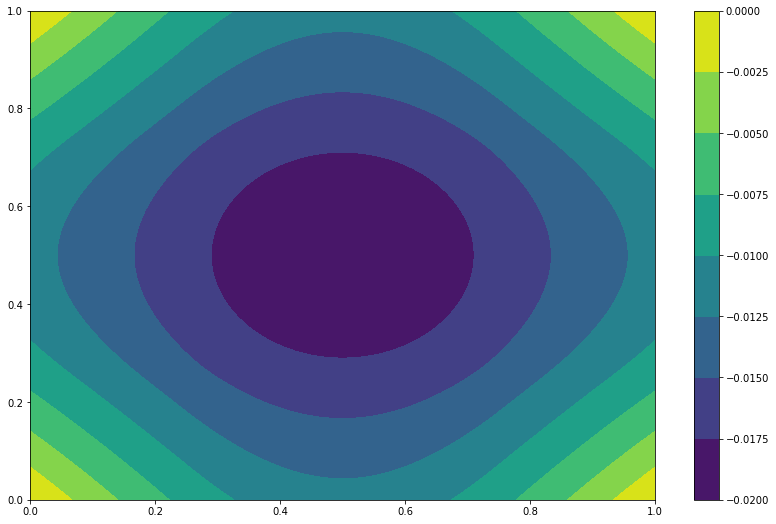

In [90]:
fig = plt.figure(figsize =(14, 9))
ax = fig.add_subplot()#projection ='3d')
plotDeformation(u,ax)

print(computeObjective(u))

plt.show()

## Shape optimization

In [92]:
# Define nonlinear constraint
nlc = opt.NonlinearConstraint(computeConstraint, 0, 0)
# Define bounds
low = coefs[interiormask]
upp = coefs[interiormask]
L = np.max(low[:,0]) - np.min(low[:,0])
W = np.max(upp[:,1]) - np.min(upp[:,1])

low[:,0] = low[:,0] - 0.5*L
low[:,1] = low[:,1] - 0.5*W
low[:,2] = low[:,2]# - 0.1*L

upp[:,0] = upp[:,0] + 0.5*L
upp[:,1] = upp[:,1] + 0.5*W
upp[:,2] = upp[:,2] + 0.02*L
low = low.flatten()
upp = upp.flatten()

bnd = opt.Bounds(low,upp,keep_feasible=False)

In [94]:
# Set initial design
u = coefs[interiormask]
u[:,2] = -0.0001*L*np.sin(u[:,0] * (np.pi) / L)*np.sin(u[:,1] * (np.pi) / L)
u = u.flatten()

print(computeObjective(u))

0.019346319438770552


In [97]:
# Shape optimization
sol = opt.minimize(computeObjective, u,
    method = 'trust-constr',
    bounds=bnd,
    constraints=nlc,
    options={   'verbose':3,
                'maxiter':5000,
                'xtol':1e-7,
                'gtol':1e-5,
                'barrier_tol':1e-5,
                })

| niter |f evals|CG iter|  obj func   |tr radius |   opt    |  c viol  | penalty  |barrier param|CG stop|
|-------|-------|-------|-------------|----------|----------|----------|----------|-------------|-------|
|   1   |  97   |   0   | +1.9346e-02 | 1.00e+00 | 3.58e-03 | 1.71e-04 | 1.00e+00 |  1.00e-01   |   0   |
|   2   |  194  |   1   | +1.8976e-02 | 5.60e+00 | 3.05e-03 | 5.39e-04 | 1.71e+00 |  1.00e-01   |   4   |
|   3   |  291  |   2   | +1.8714e-02 | 8.63e+00 | 2.48e-03 | 7.35e-04 | 1.95e+00 |  1.00e-01   |   4   |
|   4   |  388  |   4   | +1.7196e-02 | 9.08e+00 | 2.68e-03 | 2.81e-05 | 3.86e+00 |  1.00e-01   |   4   |
|   5   |  485  |   6   | +1.0914e-02 | 9.08e+00 | 1.51e-03 | 7.60e-05 | 5.33e+00 |  1.00e-01   |   4   |
|   6   |  582  |   8   | +5.9713e-03 | 9.08e+00 | 6.38e-04 | 1.06e-04 | 9.57e+00 |  1.00e-01   |   4   |
|   7   |  582  |   8   | +5.9713e-03 | 4.54e+01 | 8.57e-04 | 1.06e-04 | 1.00e+00 |  2.00e-02   |   0   |
|   8   |  679  |   9   | +6.9450e-03 | 4.54e+

|  77   | 11155 |  541  | +1.3385e-03 | 4.35e+00 | 7.85e-05 | 2.58e-10 | 1.00e+00 |  3.20e-05   |   4   |
|  78   | 11349 |  557  | +1.3385e-03 | 4.35e-01 | 7.85e-05 | 2.58e-10 | 1.00e+00 |  3.20e-05   |   4   |
|  79   | 11543 |  575  | +1.3385e-03 | 4.35e-02 | 7.85e-05 | 2.58e-10 | 1.00e+00 |  3.20e-05   |   4   |
|  80   | 11737 |  588  | +1.3364e-03 | 3.05e-01 | 1.03e-04 | 1.63e-08 | 1.00e+00 |  3.20e-05   |   2   |
|  81   | 11931 |  597  | +1.3359e-03 | 3.05e-01 | 1.10e-04 | 2.60e-09 | 1.00e+00 |  3.20e-05   |   4   |
|  82   | 12125 |  606  | +1.3354e-03 | 3.05e-01 | 6.93e-05 | 4.93e-11 | 1.00e+00 |  3.20e-05   |   4   |
|  83   | 12319 |  624  | +1.3311e-03 | 1.37e+00 | 9.95e-05 | 1.22e-06 | 1.00e+00 |  3.20e-05   |   4   |
|  84   | 12513 |  641  | +1.3272e-03 | 1.37e+00 | 8.84e-05 | 5.10e-08 | 1.00e+00 |  3.20e-05   |   4   |
|  85   | 12707 |  650  | +1.3264e-03 | 1.37e+00 | 1.14e-04 | 1.55e-10 | 1.00e+00 |  3.20e-05   |   4   |
|  86   | 12901 |  656  | +1.3260e-03 | 1.37e+

|  155  | 22795 |  867  | +1.2238e-03 | 1.04e-05 | 4.43e-04 | 1.46e-11 | 1.00e+00 |  3.20e-05   |   4   |
|  156  | 22892 |  869  | +1.2238e-03 | 2.07e-05 | 3.81e-04 | 3.01e-10 | 1.00e+00 |  3.20e-05   |   2   |
|  157  | 22989 |  872  | +1.2238e-03 | 1.45e-04 | 4.50e-04 | 5.92e-10 | 1.00e+00 |  3.20e-05   |   2   |
|  158  | 23086 |  875  | +1.2236e-03 | 1.01e-03 | 3.29e-04 | 5.35e-10 | 1.00e+00 |  3.20e-05   |   2   |
|  159  | 23183 |  878  | +1.2220e-03 | 7.10e-03 | 8.11e-03 | 1.86e-09 | 1.00e+00 |  3.20e-05   |   2   |
|  160  | 23280 |  879  | +1.2220e-03 | 7.10e-03 | 7.55e-03 | 1.39e-10 | 1.00e+00 |  3.20e-05   |   4   |
|  161  | 23377 |  880  | +1.2220e-03 | 7.10e-03 | 1.20e-03 | 3.39e-11 | 1.00e+00 |  3.20e-05   |   4   |
|  162  | 23571 |  883  | +1.2220e-03 | 3.40e-03 | 1.20e-03 | 3.39e-11 | 1.00e+00 |  3.20e-05   |   2   |
|  163  | 23765 |  886  | +1.2220e-03 | 4.00e-04 | 1.20e-03 | 3.39e-11 | 1.00e+00 |  3.20e-05   |   2   |
|  164  | 23959 |  889  | +1.2220e-03 | 4.00e-

|  233  | 31719 | 1006  | +1.2119e-03 | 8.55e-05 | 2.89e-03 | 4.41e-13 | 1.00e+00 |  3.20e-05   |   4   |
|  234  | 31816 | 1008  | +1.2118e-03 | 8.55e-05 | 1.52e-01 | 8.90e-09 | 1.00e+00 |  3.20e-05   |   2   |
|  235  | 31913 | 1009  | +1.2117e-03 | 8.55e-05 | 5.16e-02 | 1.90e-11 | 1.00e+00 |  3.20e-05   |   4   |
|  236  | 32010 | 1010  | +1.2117e-03 | 8.55e-05 | 8.42e-03 | 4.53e-12 | 1.00e+00 |  3.20e-05   |   4   |
|  237  | 32204 | 1012  | +1.2117e-03 | 8.55e-05 | 1.40e-01 | 3.09e-13 | 1.00e+00 |  3.20e-05   |   2   |
|  238  | 32301 | 1013  | +1.2116e-03 | 8.55e-05 | 1.24e-02 | 3.05e-11 | 1.00e+00 |  3.20e-05   |   4   |
|  239  | 32398 | 1015  | +1.2114e-03 | 8.55e-05 | 1.45e-01 | 2.73e-08 | 1.00e+00 |  3.20e-05   |   2   |
|  240  | 32495 | 1016  | +1.2113e-03 | 8.55e-05 | 1.71e-02 | 2.77e-11 | 1.00e+00 |  3.20e-05   |   4   |
|  241  | 32689 | 1018  | +1.2113e-03 | 4.27e-05 | 1.71e-02 | 2.77e-11 | 1.00e+00 |  3.20e-05   |   2   |
|  242  | 32883 | 1020  | +1.2113e-03 | 9.36e-

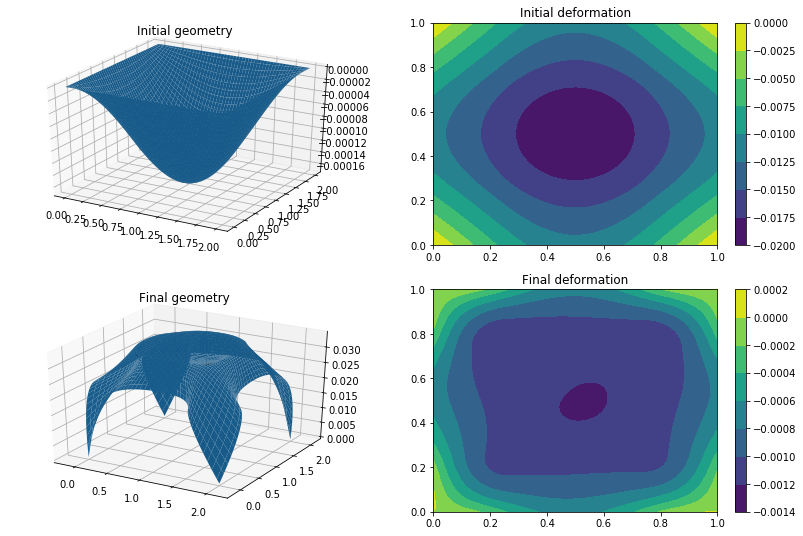

In [98]:
# Plotting
fig = plt.figure(figsize =(14, 9))
ax11 = plt.subplot(221,projection ='3d')
ax12 = plt.subplot(222)#,projection ='3d')
ax21 = plt.subplot(223,projection ='3d')
ax22 = plt.subplot(224)#,projection ='3d')

plotGeometry(u,ax11)
plotDeformation(u,ax12)

plotGeometry(sol.x,ax21)
plotDeformation(sol.x,ax22)

ax11.set_title('Initial geometry')
ax12.set_title('Initial deformation')
ax21.set_title('Final geometry')
ax22.set_title('Final deformation')

plt.show()